In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join
import json

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [2]:
root_path = '/aiffel/aiffel/kaggle_kakr_housing/data'
train_data_path = join(root_path, 'train.csv')
test_data_path = join(root_path, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
print("컬럼 정리 전 ==")
print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

# 학습 데이터에서 라벨 제거
y = train['price']
y_origin = y # y 원본 데이터가 필요할 때를 대비
del train['price']

# 불필요한 ID 컬럼 제거
del train['id'], test['id']

# 각 date 컬럼 int형으로 yyyymmd
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

print("컬럼 정리 후 ==")
print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))
assert(len(train.columns) == len(test.columns))

컬럼 정리 전 ==
train data dim : (15035, 21)
test data dim : (6468, 20)
컬럼 정리 후 ==
train data dim : (15035, 19)
test data dim : (6468, 19)


In [3]:
train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [4]:
all_data = pd.concat((train, test), axis=0)
all_data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 데이터 정리

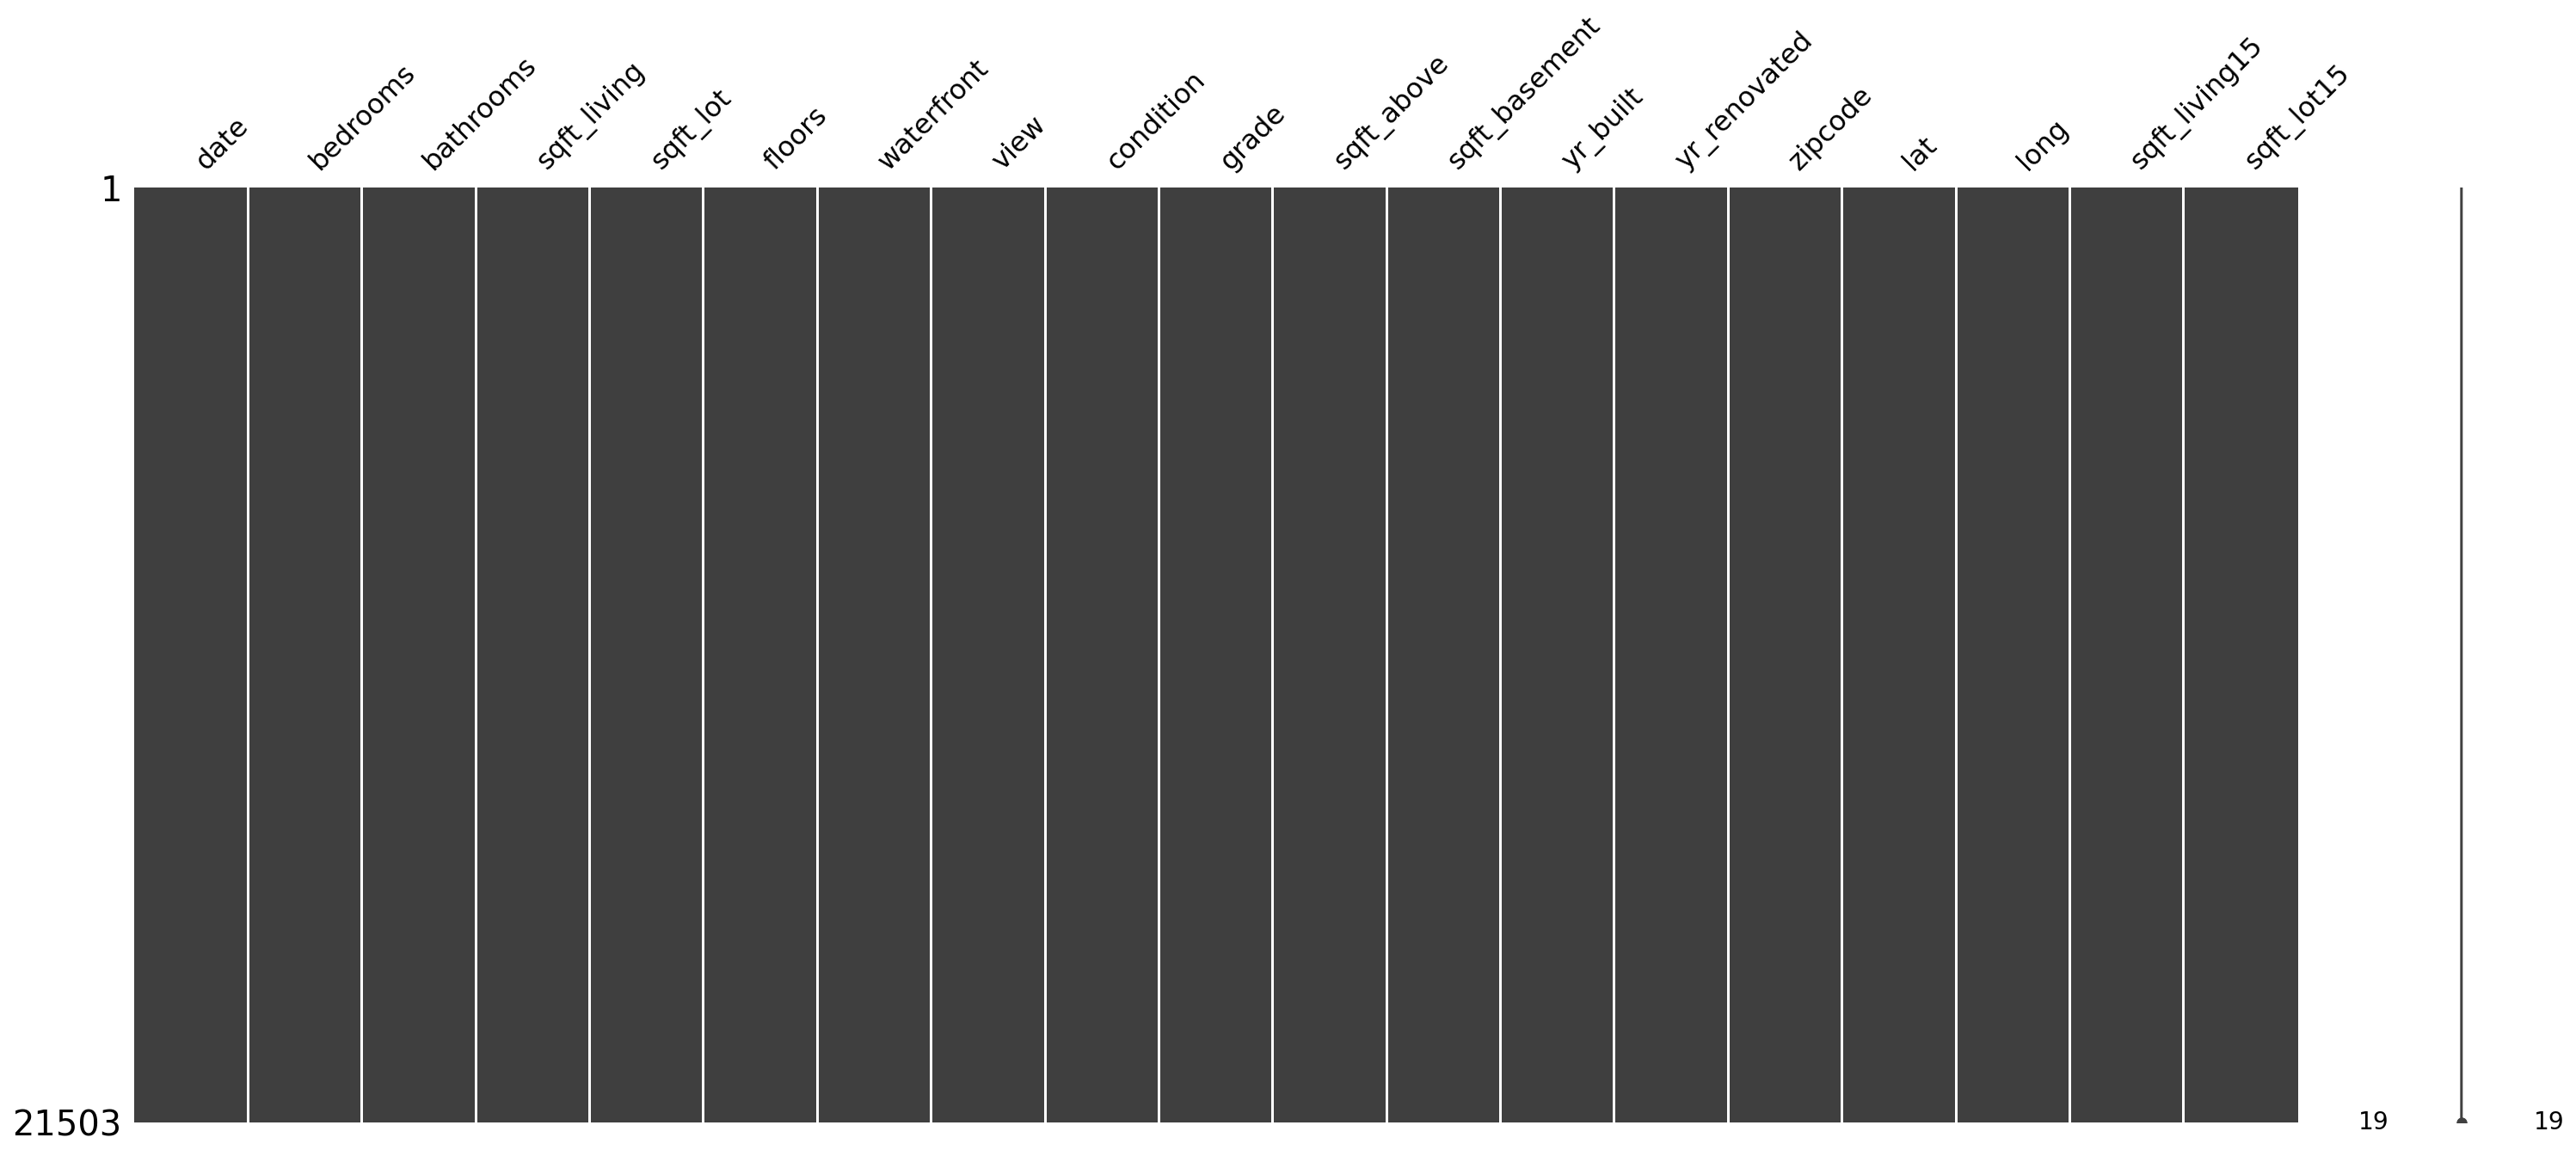

In [5]:
msno.matrix(all_data)  # 결측치 확인
plt.show()

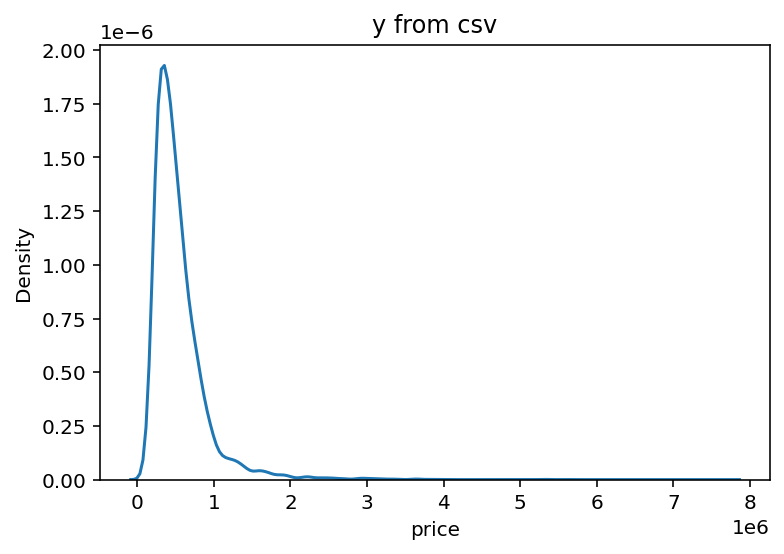

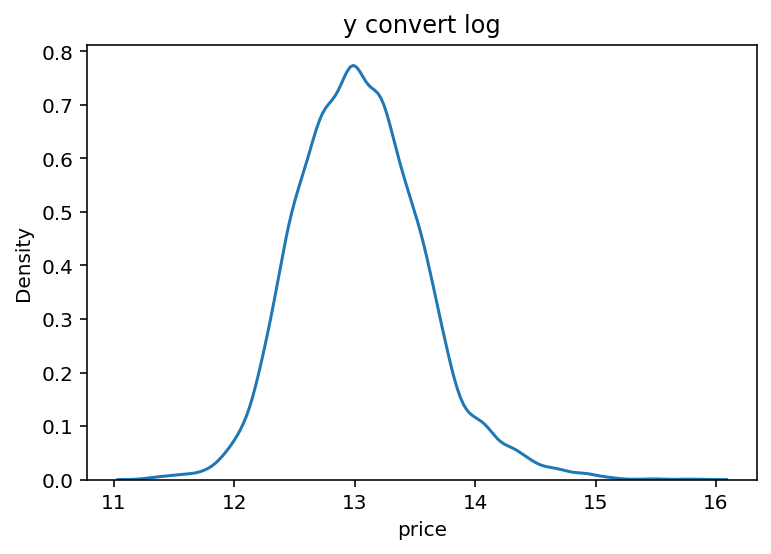

In [6]:
# 편향된 y 데이터 분산
sns.kdeplot(data=y_origin).set_title('y from csv')
plt.show()

y = np.log1p(y)
sns.kdeplot(data=y).set_title('y convert log')
plt.show()

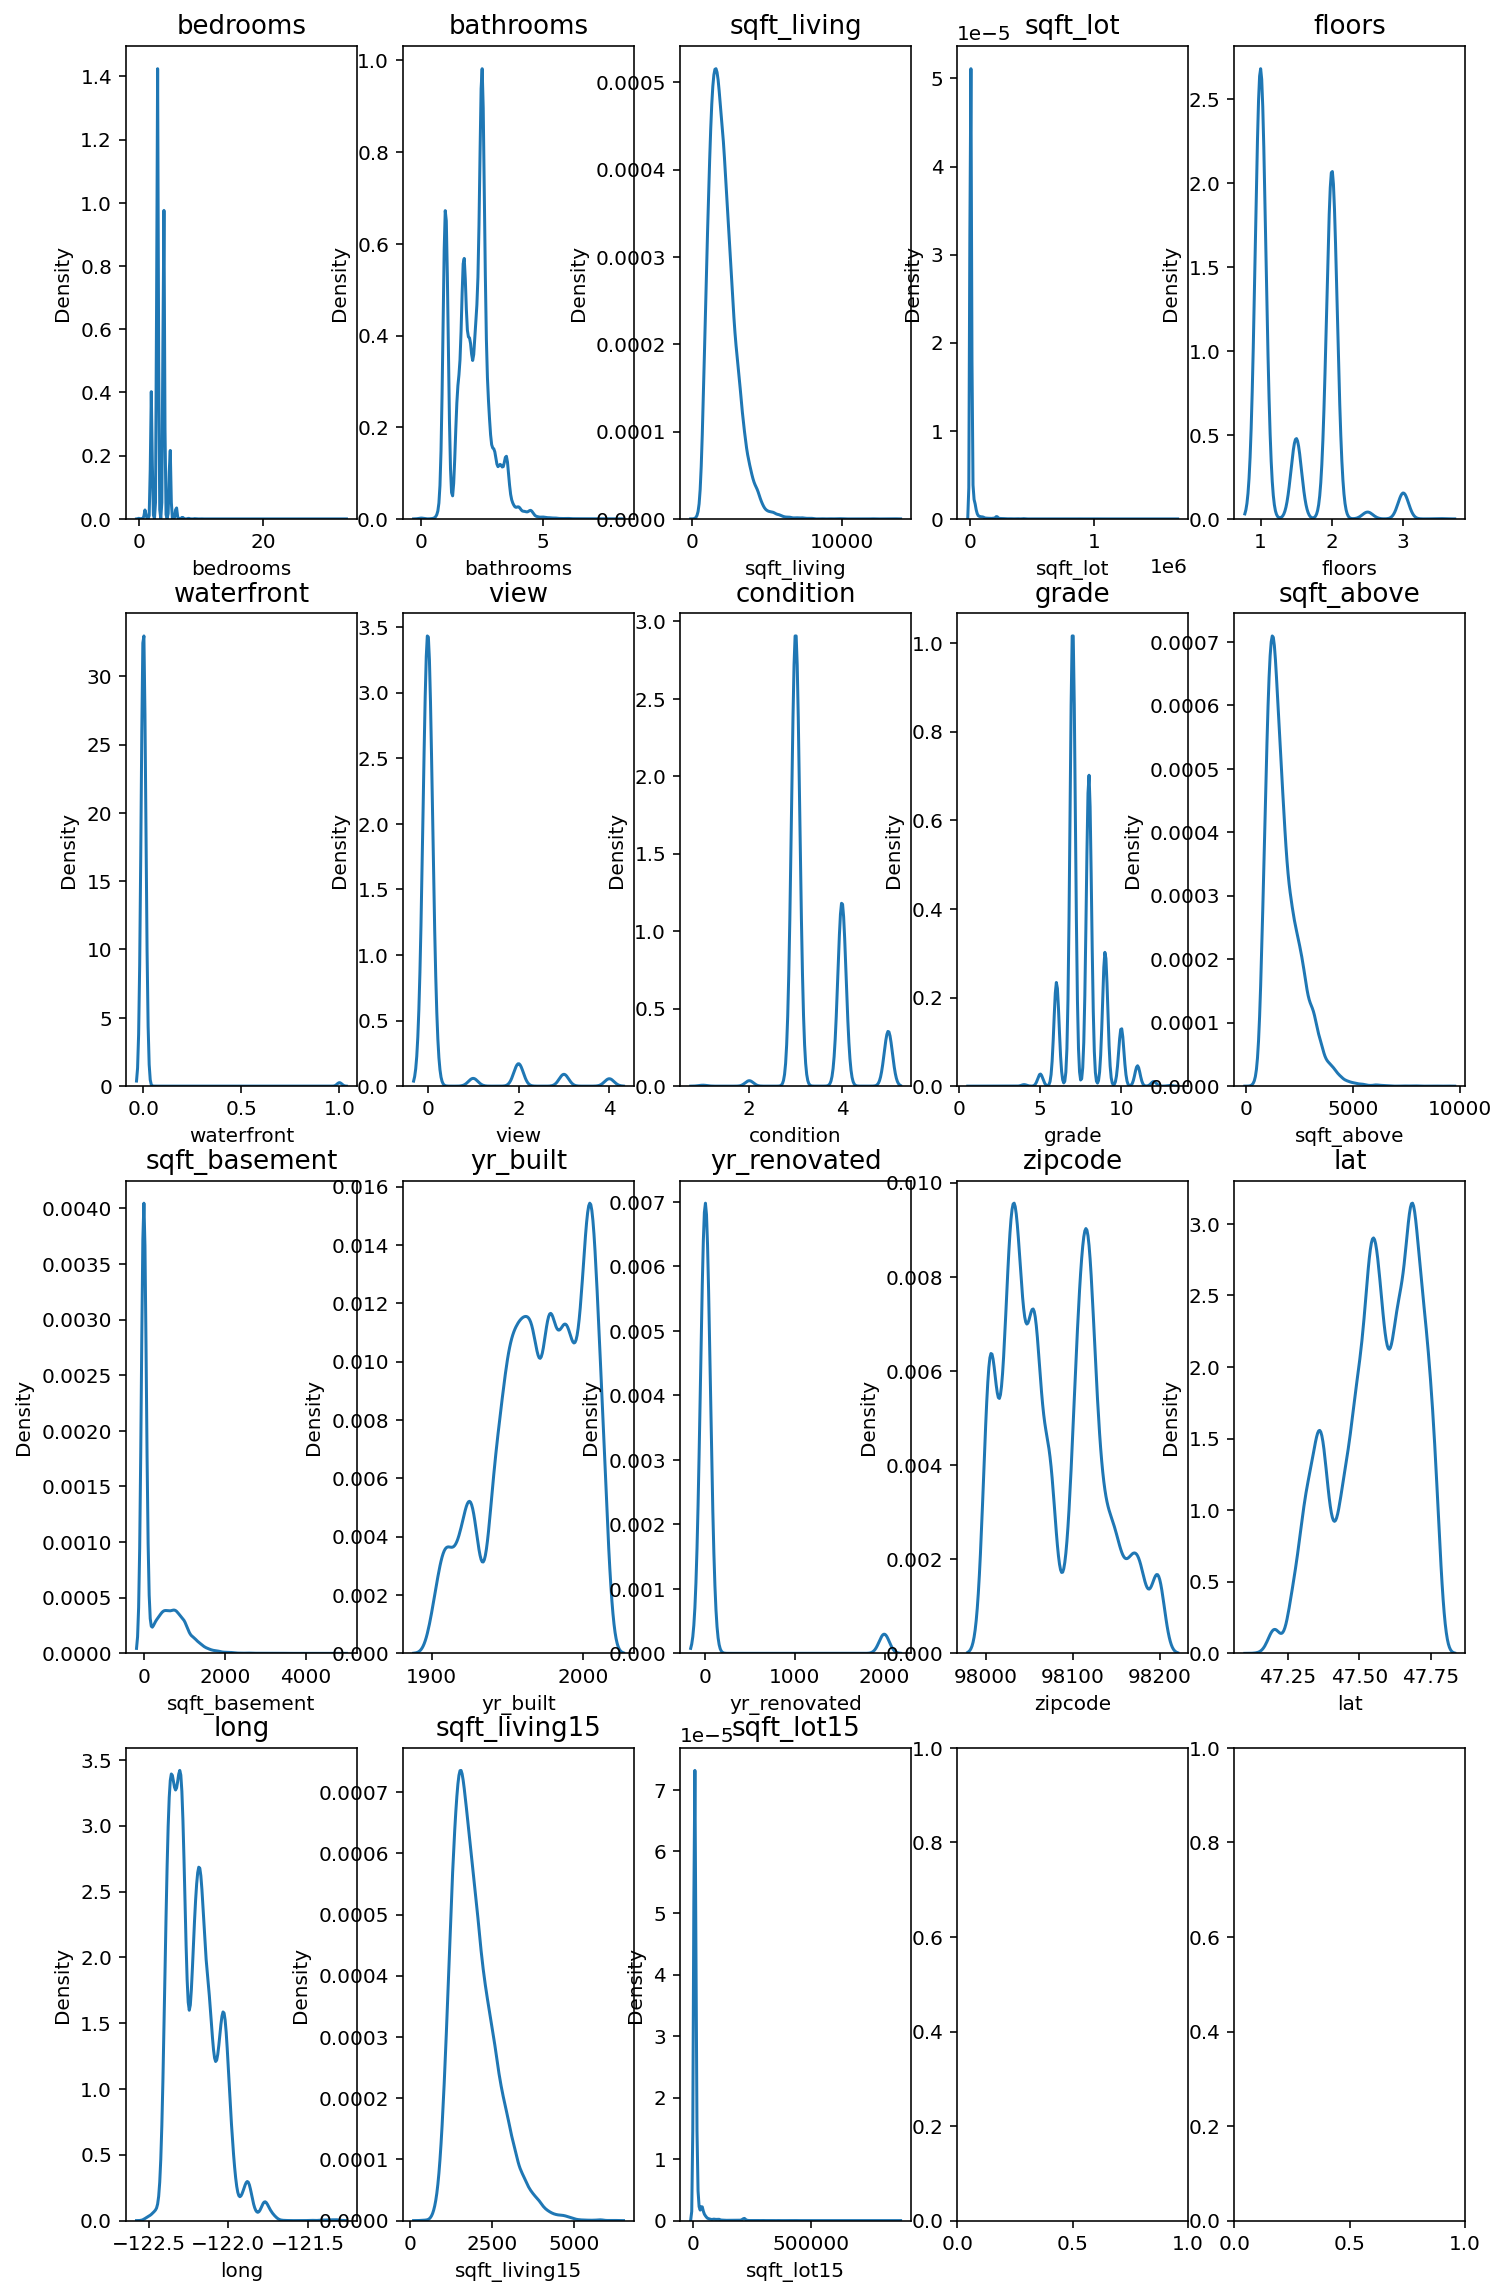

In [7]:
fig, ax = plt.subplots(4, 5, figsize=(12, 20))

# 모든 데이터 분산정도 확인
count = 1
columns = all_data.columns
for row in range(4):
    for col in range(5):
        sns.kdeplot(data=all_data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=13)
        count += 1
        if count == 19 :
            break

일부 컬럼에 한쪽으로 편향 된 데이터들이 있다. 얘넬 분산시키자

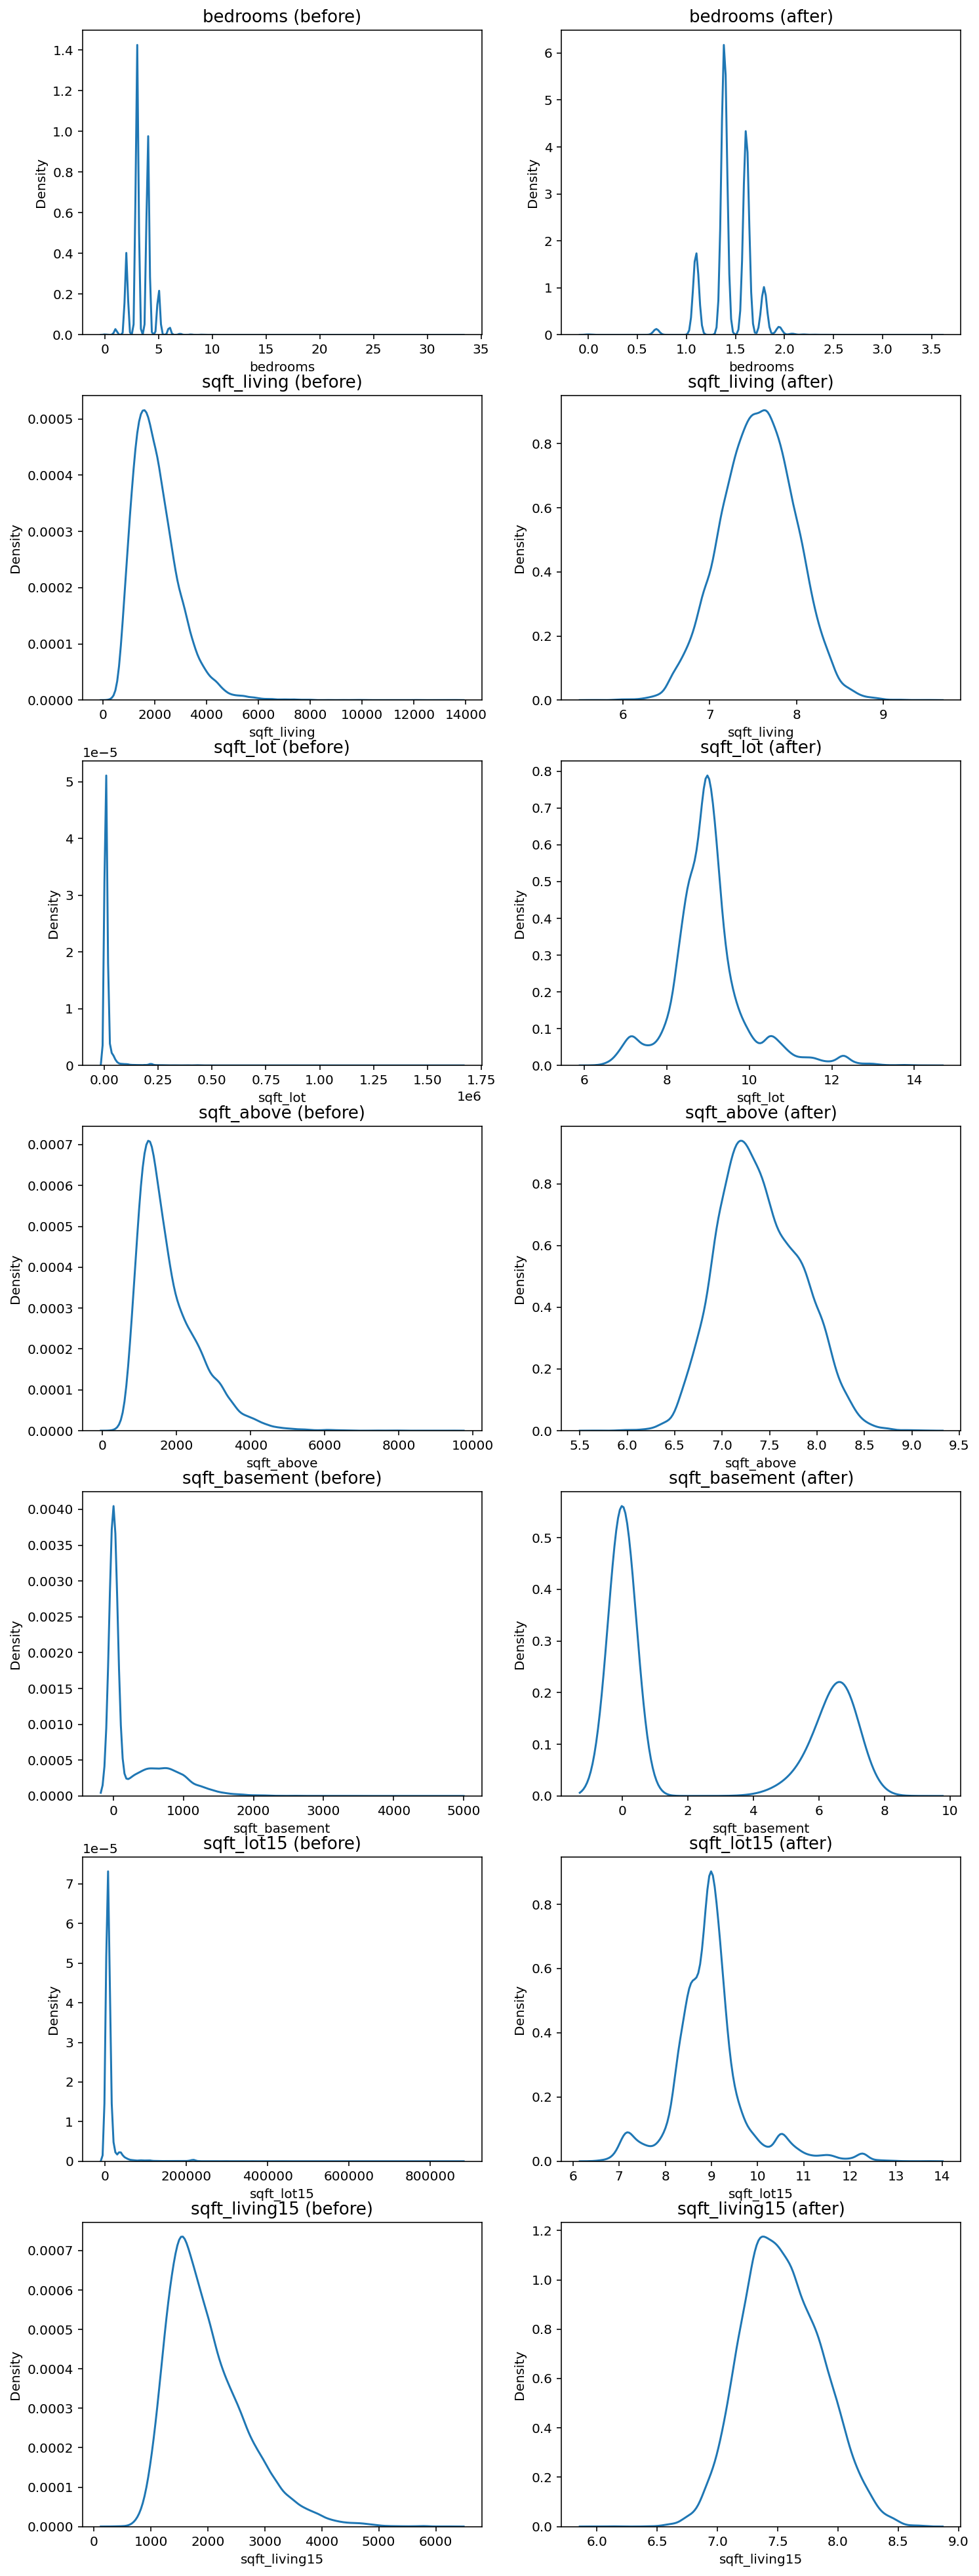

In [8]:
# 특정 컬럼데이터 분산
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']
fig, ax = plt.subplots(len(skew_columns), 2, figsize=(12, 35))

for row, c in enumerate(skew_columns):
    sns.kdeplot(data=all_data[c], ax=ax[row][0])
    ax[row][0].set_title(f"{c} (before)", fontsize=13)

    all_data[c] = np.log1p(all_data[c].values)
    sns.kdeplot(data=all_data[c], ax=ax[row][1])
    ax[row][1].set_title(f"{c} (after)", fontsize=13)

In [9]:
train_len = len(train)
train2 = all_data.iloc[:train_len, :]
test2 = all_data.iloc[train_len:, :]

assert(train_len == len(train2))
print(train2.shape)
print(test2.shape)

(15035, 19)
(6468, 19)


## 3. 모델 성능확인

In [10]:
random_state=2020
X_train, X_test, y_train, y_test = train_test_split(train2, y, random_state=random_state, test_size=0.2)

In [11]:
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [
    {'model':gboost, 'name':'GradientBoosting'},
    {'model':xgboost, 'name':'XGBoost'},
    {'model':lightgbm, 'name':'LightGBM'},
    {'model':rdforest, 'name':'RandomForest'},
]

In [12]:
def prettier(data):
    "데이터 확인 용이하게 JSON으로 Print"

    print(json.dumps(data, indent=2))

In [13]:
def get_cv_score(models, x, y):
    "모델 CV 스코어 판별"

    result = {}
    kfold = KFold(n_splits=5).get_n_splits(x)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x, y=y, cv=kfold))
        result[m['name']] = CV_score
    
    return dict(sorted(result.items(), key=lambda x: -x[1]))

In [14]:
prettier(get_cv_score(models, train2.values, y))

{
  "LightGBM": 0.902497167811601,
  "XGBoost": 0.8973194882355615,
  "RandomForest": 0.8851189827892357,
  "GradientBoosting": 0.8796548287752909
}


In [15]:
def AveragingBlending(models, x, y, sub_x):
    "모델 블랜딩"

    for m in models : 
        m['model'].fit(x, y)

    predictions = np.column_stack([
        m['model'].predict(sub_x) for m in models
    ])

    return np.mean(predictions, axis=1)

In [16]:
y_pred = AveragingBlending(models, train2.values, y, test2.values)
print(len(y_pred))
print(y_pred)

6468
[13.12155829 13.02047159 14.07489914 ... 13.03144944 12.71654465
 12.99392785]


In [17]:
def rmse(y_test, y_pred):
    "로그변환 값들 원상복귀"

    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [18]:
def get_scores(models, X_train, X_test, y_train, y_test):
    df = {}

    for model in models:
        model_name = model['name']
        model['model'].fit(X_train, y_train)
        y_pred = model['model'].predict(X_test)
        df[model_name] = rmse(y_test, y_pred)

    return pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

get_scores(models, X_train, X_test, y_train, y_test)

,RMSE
GradientBoosting,128370.486911
RandomForest,125299.591549
LightGBM,111906.268088
XGBoost,110319.723794


## 3. GridSearch를 활용한 하이퍼파라미터 실험

GridSearchCV의 인자들
* param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
* scoring : 모델의 성능을 평가할 지표
* cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
* verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
* n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수

In [19]:
param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [10, 15],
    'learning_rate':[0.05]
}

In [20]:
def grid_per_model(models, param_grid, x, y):
    data = []
    for model in models:
        # GridSearch를 통한 하이퍼파라미터 튜닝시 너무 느려서 우선 배제
        if model['name'] == "XGBoost": continue
        
        model_name = model['name']
        try:
            grid_model = GridSearchCV(model['model'], param_grid=param_grid, \
                                    scoring='neg_mean_squared_error', \
                                    cv=5, verbose=1, n_jobs=5)

            grid_model.fit(x, y)
            params = grid_model.cv_results_['params']
            scores = grid_model.cv_results_['mean_test_score']

            per_model = [
                dict(
                    Model=model_name,
                    RMSE=np.sqrt(-1 * score),
                    **param
                )
                for param, score in zip(params, scores)
            ]

            data.extend(per_model)
            print("----------- Done!")
        except Exception as e:
            print(model_name)
            print("Exception!!", e)

    return pd.DataFrame(data).sort_values('RMSE')

models_grid = [
    {'model':gboost, 'name':'GradientBoosting'},
    {'model':lightgbm, 'name':'LightGBM'},
]

result = grid_per_model(models_grid, param_grid, x=train2, y=y)
result

Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------- Done!
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------- Done!


,Model,RMSE,learning_rate,max_depth,n_estimators
4,LightGBM,0.161021,0.05,10,500
5,LightGBM,0.161027,0.05,10,1000
7,LightGBM,0.161195,0.05,15,1000
6,LightGBM,0.161220,0.05,15,500
0,GradientBoosting,0.171299,0.05,10,500
1,GradientBoosting,0.171306,0.05,10,1000
3,GradientBoosting,0.196143,0.05,15,1000
2,GradientBoosting,0.196143,0.05,15,500


```python
models = [LightGBM, GradientBoosting]
random_state=2020
param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [10, 15],
    'learning_rate':[0.05]
}
```
위 조합 중에선
* LightGBM(learning_rate=0.05, max_depth=10, n_estimators=500)
* GradientBoosting(learning_rate=0.05, max_depth=10, n_estimators=500)

경우일 때 나은 성능을 보이는 것 같다. 두개 모델로 단일결과, 앙상블 결과를 뽑아서 제출해봐야겠다

## 4. 결과 저장하기(Single, Ensemble)

In [21]:
def save_submission(model_name, prediction, rmsle=None):
    submission_path = join(root_path, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(root_path, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [22]:
models3 = [
    {
        'model': LGBMRegressor(learning_rate=0.05, max_depth=10, n_estimators=500, random_state=random_state),
        'name': 'LGBM'
    },
    {
        'model': GradientBoostingRegressor(learning_rate=0.05, max_depth=10, n_estimators=500, random_state=random_state),
        'name': 'GradientBoost'
    },
]

### LGBM 단독

In [23]:
models3[0]['model'].fit(train2, y)
prediction1 = models3[0]['model'].predict(test)
save_submission("Single_LGBM", np.expm1(prediction1), '10_500')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_Single_LGBM_RMSLE_10_500.csv saved!


### GradientBoost 단독

In [24]:
models3[1]['model'].fit(train2, y)
prediction2 = models3[1]['model'].predict(test)
save_submission("Single_GradientBoost", np.expm1(prediction2), '10_500')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_Single_GradientBoost_RMSLE_10_500.csv saved!


### LGBM+GradientBoost 앙상블

In [25]:
predictions3 = np.column_stack([
    prediction1,
    prediction2,
])

prediction3 = np.mean(predictions3, axis=1)
save_submission("Mixed_LGBM_GBoost", np.expm1(prediction3), '10_500')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_Mixed_LGBM_GBoost_RMSLE_10_500.csv saved!


## 회고

* LGBM과 GradientBoosting 두개 모델로 하이퍼파라미터 튜닝을 진행했다
    * XGBoost 모델은 GridSearch가 진행이 안 될 정도로 느려서 포기했고
    * RandomForest 모델은 learning_rate 파라미터 적용이 안되는 것도 있지만 n_estimators, max_depth 수치를 조정해도 좋은 성능을 보여주진 못했었다.
* n_estimators, max_depth, learning_rate 값에 따라 미세하게 성능에 차이를 보였다
* 하지만 캐글 점수엔 한참 못미친 성적이다. 궁극적으로 다른 모델을 차용하거나, 기본 데이터를 바탕으로 예측에 도움 될 추가 데이터들을 조합해서 도전해야 점수 상향이 가능할 것 같다